## TO DO LIST

##### Deze week

* **[DONE]** Voertuig/passagier logging verbeteren
* **[DONE]** Overstap mogelijk maken
* **[DONE]** Voertuig moet de juiste mensen meenemen
* **[DONE]** Keuzes toevoegen op basis van class
* Overstap-/wachttijd
  * Wachttijd voor reis door departure - creation
  * Wachttijd updaten bij elke overstap
  * Overstaptijd delay toevoegen
  * Overstaptijd is x * aantal keren overstappen
* Bepaalde verdeling van mensen simuleren


##### Volgende week
* Nodes samen nemen
* Meer voertuigen toevoegen
* Netwerk uitbreiden

In [1]:
# Package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# You need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# Spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# Package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module
import transport_network_analysis.model as model

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

### Import data

In [2]:
# Import stations and lines from excel sheets
df1 = pd.read_csv("../../stations.csv")
df2 = pd.read_csv("../../lijnen.csv")

# Convert columns to lst type
from ast import literal_eval
df2.loc[:,'Route1'] = df2.loc[:,'Route1'].apply(lambda x: literal_eval(x))
df2.loc[:,'Route2'] = df2.loc[:,'Route2'].apply(lambda x: literal_eval(x))
df2.loc[:,'Duration'] = df2.loc[:,'Duration'].apply(lambda x: literal_eval(x))

In [3]:
df1 = df1.drop([2, 3, 4, 5])
df1

,Unnamed: 0,HalteNaam,HalteLat,HalteLon,Capacity,Line
0,0,Noord,52.401172,4.931232,100,metro52
1,1,Noorderpark,52.388555,4.917891,100,metro52
6,6,Europaplein,52.341855,4.891384,100,metro52
7,7,Zuid,52.339080,4.875099,100,metro52
8,8,CentraalStation,52.377720,4.901043,100,tram24
9,9,Dam,52.374929,4.895494,100,tram24
10,10,Rokin,52.369855,4.892305,100,tram24
11,11,Muntplein,52.366462,4.893238,100,tram24
12,12,Vijzelgracht,52.360297,4.891120,100,tram24
13,13,MarieHeinekenplein,52.357221,4.890772,100,tram24


In [4]:
# Create dictionary for all transport lines
lines = {}
durations = []

for index, row in df2.iterrows():
    lines[row["Line"]] = (row["Route1"], row["Route2"], row["Duration"])
    
edges = []
for k, v in lines.items():
    for x in range(len(v[0])):
        try:
            edges.append((v[0][x], v[0][x + 1], k, v[2][x]))
            edges.append((v[0][x + 1], v[0][x], k, v[2][x]))
        except:
            break

### Create graph

In [5]:
# Create graph
FG = nx.DiGraph()

# Create all stations and nodes
Node = type('Station', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.Station), {})
nodes = []
stations = []

for index, row in df1.iterrows():
    stations.append({"env": [],
                     "name": row["HalteNaam"],
                     "geometry": shapely.geometry.Point(row["HalteLat"], row["HalteLon"]),
                     "capacity": row["Capacity"]}) 

for station in stations:
    node = Node(**station)
    nodes.append(node)

# Create positions and add nodes to graph with right position
positions = {}

for node in nodes:
    positions[node.name] = (node.geometry.y, node.geometry.x)
    FG.add_node(node.name, geometry = node.geometry, object_type = node)

# Create all edges
for edge in edges:
    FG.add_edge(edge[0], edge[1], line = edge[2], duration = edge[3])

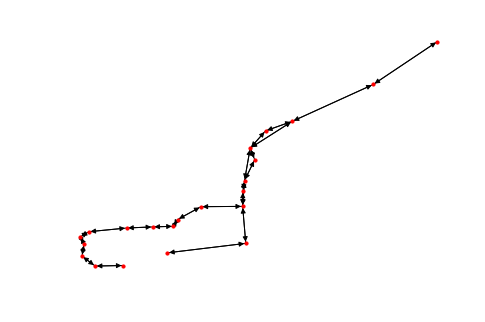

In [6]:
# Plot the network
nx.draw(FG, positions, node_size=10)
plt.show()

In [7]:
# Calculate transfers and durations
def route_calculation(route, graph):
    route_info = {"lines": [], "duration": 0, "transfers": 0, "waiting": 0, "transferstations": []}
    
    for i in range(len(route) - 1):
        if route_info["lines"] != []:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            if line != attr['line']:
                route_info["transfers"] += 1
                route_info["transferstations"].append(route[i])
                line = attr['line']
                route_info["lines"].append(line) 
        else:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            line = attr['line']
            route_info["lines"].append(line) 

        route_info["duration"] += attr['duration']
        
    route_info["waiting"] = int(random.random() * 10)
    route_info["duration"] += (route_info["transfers"] * 3)
    
    return route_info

In [8]:
def choice(routes, classname):
    if classname == 0:
        minimum = routes[0][0]["duration"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the shortest trip duration
            if routes[i][0]["duration"] < minimum:
                minimum = routes[i][0]["duration"]
                index = i

            # If the duration is the same, save the route with the least waiting time
            elif routes[i][0]["duration"] == minimum:
                if routes[i][0]["waiting"] < routes[index][0]["waiting"]:
                    index = i

    elif classname == 1:
        minimum = routes[0][0]["waiting"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the least waiting time
            if routes[i][0]["waiting"] < minimum:
                minimum = routes[i][0]["waiting"]
                index = i

            # If waiting time is the same, save the route with the shortest duration
            elif routes[i][0]["waiting"] == minimum:
                if routes[i][0]["duration"] < routes[index][0]["duration"]:
                    index = i

    elif classname == 2:
        minimum = routes[0][0]["transfers"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the least transfers
            if routes[i][0]["transfers"] < minimum:
                minimum = routes[i][0]["transfers"]
                index = i

            # If the num of transfers is the same, save the route with the shortes duration
            elif routes[i][0]["transfers"] == minimum:
                if routes[i][0]["duration"] < routes[index][0]["duration"]:
                    index = i
                    
    return routes[index][0], routes[index][1]

### Create moving parts

In [9]:
def generate_passenger(origin, destination, classname, environment):
    """ Generate a passenger """
    Passenger = type('Passenger', (core.Identifiable, core.Routeable, core.Log), {})
    
    # Name of the object
    name = "Passenger"
    
    # Geometry of the origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[origin].geometry
 
    paths = nx.all_simple_paths(environment.FG, source = origin, target = destination)    
    
    routes = []
    for path in paths:
        routes.append(((route_calculation(path, FG)), path))

    # Travel direction and route information
    route_info, route = choice(routes, classname)    
        
    return Passenger(**{"env": environment, 
                        "name": name, 
                        "route": route,
                        "route_info": route_info,
                        "transfers": route_info["transfers"],
                        "transferstations": route_info["transferstations"].copy(),
                        "duration": route_info["duration"],
                        "lines": route_info["lines"].copy(),
                        "class_id": classname
                        })

In [10]:
def generate_vehicle(line, environment, linename):
    """ Generate a metro """
    Vehicle = type(linename, (core.Identifiable, core.Movable, core.HasContainer, core.HasResource, 
                           core.Routeable, core.Mover), {})
    # Name of the object
    name = linename

    # Travel direction
    route = line    

    # Geometry of origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[route[0]].geometry
    
    # Maximum passengers
    capacity = 200
    
    return Vehicle(**{"env": environment, 
                    "name": name, 
                    "route": route, 
                    "capacity": capacity, 
                    "geometry": geometry
                   })

### Spawn the metro trains

In [11]:
def vehicle(env, start, frequency, name, x):
    yield env.timeout(start * 60 * 60)
    while True:
        vehicle = generate_vehicle(lines[name][x], env, name)
        env.vehicles.append(vehicle)
        env.process(vehicle.move())
        
        # One vehicle every X minutes
        yield env.timeout(frequency * 60)

In [12]:
def passengers(env, classname):
    yield env.timeout(5.5 * 60 * 60)
    while True:
        origin, destination = random.sample(env.FG.nodes, 2)

        passenger = generate_passenger(origin, destination, classname, env)
        FG.nodes[origin]["object_type"].units.append(passenger)

        passenger.log_entry("Waiting for {}".format(passenger.lines[0]), env.now, 0, nx.get_node_attributes(env.FG, "object_type")[origin].geometry)
        
        env.passengers.append(passenger)

        # Random arrivals of passengers with mean interarrival time of 30 seconds
        yield env.timeout(random.random() * 60)

### Run simulation

In [13]:
# Simulation start time
simulation_start = datetime.datetime(2019, 1, 1)

# Make simulation environment
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.FG = FG

# For loggin
env.vehicles = []
env.passengers = []

# Start the simulation
env.process(vehicle(env, 5.5, 6, "metro52", 0))
env.process(vehicle(env, 5.585, 6, "metro52", 1))
env.process(vehicle(env, 6, 10, "tram24", 0))
env.process(vehicle(env, 6, 10, "tram24", 1))
env.process(passengers(env, 0))
env.run(until = env.now + 1 * 24 * 60 * 60)

### Check results

In [14]:
pd.DataFrame.from_dict(env.vehicles[4].log)

,Message,Timestamp,Value,Geometry
0,Loading start,2019-01-01 05:42:00,0,POINT (52.40117202 4.93123182)
1,Loading stop,2019-01-01 05:42:00,30,POINT (52.40117202 4.93123182)
2,Driving from node Noord to node Noorderpark start,2019-01-01 05:42:00,0,POINT (52.40117202 4.93123182)
3,Driving from node Noord to node Noorderpark stop,2019-01-01 05:44:00,0,POINT (52.38855518 4.91789115)
4,Unloading start,2019-01-01 05:44:00,0,POINT (52.38855518 4.91789115)
5,Unloading stop,2019-01-01 05:44:00,30,POINT (52.38855518 4.91789115)
6,Loading start,2019-01-01 05:44:30,0,POINT (52.38855518 4.91789115)
7,Loading stop,2019-01-01 05:44:30,30,POINT (52.38855518 4.91789115)
8,Driving from node Noorderpark to node Centraal...,2019-01-01 05:44:30,0,POINT (52.38855518 4.91789115)
9,Driving from node Noorderpark to node Centraal...,2019-01-01 05:46:30,0,POINT (52.37771998 4.90104337)


In [20]:
pd.DataFrame.from_dict(env.passengers[5].log)

,Message,Timestamp,Value,Geometry
0,Waiting for tram24,2019-01-01 05:32:15.841930,0,POINT (52.34380875 4.85696449)
1,Waiting for tram24 stop,2019-01-01 06:08:00.000000,0,POINT (52.34380875 4.85696449)
2,In tram24 start,2019-01-01 06:08:00.000000,0,POINT (52.34380875 4.85696449)
3,In tram24 stop,2019-01-01 06:17:00.000000,0,POINT (52.34886793 4.87720177)


In [21]:
passengerdict = {}

for i in range(len(env.passengers)):
    try:
        passengerdict[env.passengers[i].id] = {"route": env.passengers[i].route, 
                                        "origin": env.passengers[i].route[0], 
                                        "destination": env.passengers[i].route[-1], 
                                        "transfers": env.passengers[i].route_info['transfers'], 
                                        "lines": env.passengers[i].route_info['lines'], 
                                        "transferstations": env.passengers[i].route_info['transferstations'], 
                                        "creation": env.passengers[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "departure": env.passengers[i].log["Timestamp"][2].strftime ('%H:%M:%S'),
                                        "arrival": env.passengers[i].log["Timestamp"][3].strftime ('%H:%M:%S'), 
                                        "date": env.passengers[i].log["Timestamp"][0].date(),
                                        "class_id": env.passengers[i].class_id, 
                                        "waiting_time": 0}
    except:
        pass
    
passengerdf = pd.DataFrame(passengerdict).T
passengerdf.to_csv("../../passengers.csv", index=True)

In [22]:
passengerdf

,arrival,class_id,creation,date,departure,destination,lines,origin,route,transfers,transferstations,waiting_time
313453da-7188-11e9-a6dd-7831c1d08f6a,06:19:30,0,05:30:00,2019-01-01,06:05:00,RoelofHartplein,[tram24],Amstelveenseweg,"[Amstelveenseweg, IJsbaanpad, OlympischStadion...",0,[],0
31349dcc-7188-11e9-b653-7831c1d08f6a,06:25:30,0,05:30:15,2019-01-01,06:17:30,MarieHeinekenplein,[tram24],GerritvdVeenstraat,"[GerritvdVeenstraat, RoelofHartplein, DePijp, ...",0,[],0
3134a9d4-7188-11e9-8e55-7831c1d08f6a,06:27:00,0,05:30:59,2019-01-01,06:17:30,Vijzelgracht,[tram24],GerritvdVeenstraat,"[GerritvdVeenstraat, RoelofHartplein, DePijp, ...",0,[],0
3134b3fa-7188-11e9-9e37-7831c1d08f6a,06:17:00,0,05:31:12,2019-01-01,06:12:00,GerritvdVeenstraat,[tram24],Olympiaplein,"[Olympiaplein, Minervaplein, Beethovenstraat, ...",0,[],0
3134ccca-7188-11e9-9f98-7831c1d08f6a,05:48:00,0,05:31:28,2019-01-01,05:36:00,Minervaplein,"[metro52, tram24]",Noord,"[Noord, Noorderpark, CentraalStation, Rokin, V...",1,[DePijp],0
3134d6ca-7188-11e9-9ee2-7831c1d08f6a,06:17:00,0,05:32:15,2019-01-01,06:08:00,GerritvdVeenstraat,[tram24],OlympischStadion,"[OlympischStadion, Olympiaweg, Olympiaplein, M...",0,[],0
3134e534-7188-11e9-a6ec-7831c1d08f6a,06:23:30,0,05:32:56,2019-01-01,06:15:00,Minervaplein,[tram24],DePijp,"[DePijp, RoelofHartplein, GerritvdVeenstraat, ...",0,[],0
3134ef3e-7188-11e9-ba95-7831c1d08f6a,06:25:30,0,05:33:22,2019-01-01,06:17:30,MarieHeinekenplein,[tram24],GerritvdVeenstraat,"[GerritvdVeenstraat, RoelofHartplein, DePijp, ...",0,[],0
31350458-7188-11e9-835d-7831c1d08f6a,05:40:36,0,05:33:36,2019-01-01,05:35:06,IJsbaanpad,"[metro52, tram24]",Zuid,"[Zuid, Europaplein, DePijp, RoelofHartplein, G...",1,[DePijp],0
31350ce4-7188-11e9-8092-7831c1d08f6a,06:14:00,0,05:33:57,2019-01-01,06:02:30,Minervaplein,[tram24],VUMedischCentrum,"[VUMedischCentrum, Amstelveenseweg, IJsbaanpad...",0,[],0


In [18]:
vehicledict = {}

for i in range(len(env.vehicles)):
    try:
        vehicledict[env.vehicles[i].id] = {"route": env.vehicles[i].route, 
                                        "line": env.vehicles[i].name, 
                                        "departure": env.vehicles[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "arrival": env.vehicles[i].log["Timestamp"][-1].strftime ('%H:%M:%S'), 
                                        "date": env.vehicles[i].log["Timestamp"][0].date()}
    except:
        pass
    
vehicledf = pd.DataFrame(vehicledict).T
vehicledf.to_csv("../../vehicles.csv", index=True)

In [19]:
vehicledf

,arrival,date,departure,line,route
31341546-7188-11e9-8cc8-7831c1d08f6a,05:48:00,2019-01-01,05:30:00,metro52,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
31353e94-7188-11e9-889b-7831c1d08f6a,05:53:06,2019-01-01,05:35:06,metro52,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
31355e74-7188-11e9-bbb1-7831c1d08f6a,05:54:00,2019-01-01,05:36:00,metro52,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
31367ffa-7188-11e9-94fa-7831c1d08f6a,05:59:06,2019-01-01,05:41:06,metro52,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
3136c1e2-7188-11e9-977d-7831c1d08f6a,06:00:00,2019-01-01,05:42:00,metro52,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
3137f17a-7188-11e9-9f81-7831c1d08f6a,06:05:06,2019-01-01,05:47:06,metro52,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
31380e80-7188-11e9-b7d5-7831c1d08f6a,06:06:00,2019-01-01,05:48:00,metro52,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
313937f6-7188-11e9-bb0c-7831c1d08f6a,06:11:06,2019-01-01,05:53:06,metro52,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
31395e52-7188-11e9-b6ef-7831c1d08f6a,06:12:00,2019-01-01,05:54:00,metro52,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
313a62ca-7188-11e9-933d-7831c1d08f6a,06:17:06,2019-01-01,05:59:06,metro52,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
